In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Downloading the data**

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [4]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

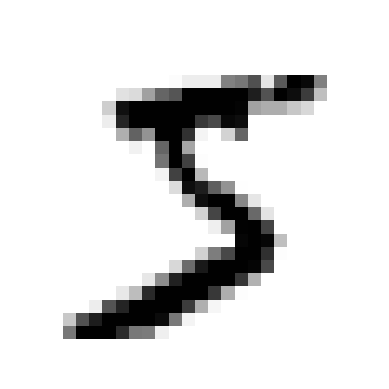

In [10]:
# Plot one image
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)

In [11]:
# Create a test set and set it aside
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Training a Binary Classifier**

In [12]:
# Train a "5-detector"
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [13]:
# SGD
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

**Performance Measures**

In [19]:
# Accuracy
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
# Dummy classifier
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))  # prints False: no 5s detected (always predicts the most frequent class)

False


In [21]:
# Over 90% accuracy for the dummy classifier :-P
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [22]:
# How to implement cross-validation manually
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

sklfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is 
                                        # not already shuffled
for train_index, test_index in sklfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [26]:
# The StratifiedKFold class performs stratified sampling to produce folds that contain 
# a representative ratio of each class.
print(np.count_nonzero(y_train_5) / y_train_5.size)
print(np.count_nonzero(y_train_folds) / y_train_folds.size)
print(np.count_nonzero(y_test_fold) / y_test_fold.size)

0.09035
0.09035
0.09035


**Confusion Matrices**

In [27]:
# Obtain some predictions
from sklearn.model_selection import cross_val_predict

# Each sample belongs to exactly one validation set. So at the end, 
# y_train_pred has the same size as the training set.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [28]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)

# Each row represents an ACTUAL class. Each column represents a PREDICTED class
# [[True Negative,  False Postive],
#  [False Negative, True Positive]]
cm

array([[53892,   687],
       [ 1891,  3530]])

In [29]:
# A perfect classifier has non-zero values only on the main diagonal
y_train_perfect_pred = y_train_5  # Pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]])

**Precision and Recall**

In [30]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))  # == 3530 / (687 + 3530)
print(recall_score(y_train_5, y_train_pred))  # == 3530 / (1891 + 3530)

0.8370879772350012
0.6511713705958311


In [31]:
# f1 score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [35]:
# Bigger threshold means increased precision, decreased recall
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [36]:
# Which threshold to use? First get the decision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [38]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

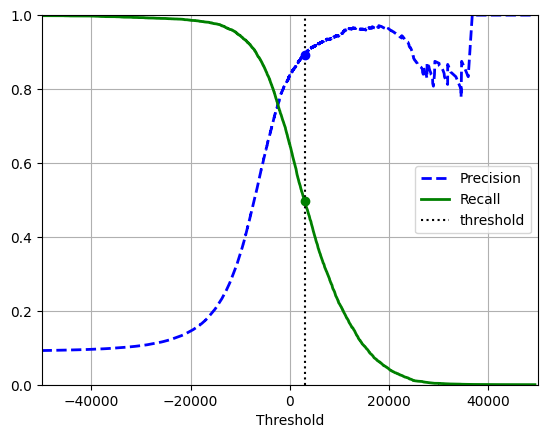

In [43]:
# The last precision and recall values are 1. and 0. respectively and do not have a corresponding threshold.
# This ensures that the graph starts on the y axis.
plt.plot(thresholds, precisions[:-1], 'b--', label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

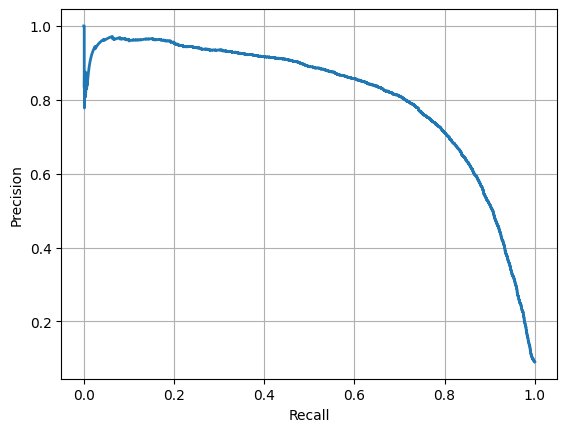

In [46]:
# plot precision vs recall directly
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

In [47]:
idx_for_90_precision = (precisions >= 0.90).argmax()  # first index of the maximum value
                                                      # -> index of the first True value
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.019499144183

In [52]:
# Alternatively...
(precisions >= 0.90).nonzero()[0][0]

57109

In [53]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [55]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [56]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

**The ROC Curve**

In [57]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [58]:
thresholds.max(), thresholds.min()

(inf, -146348.56726173745)

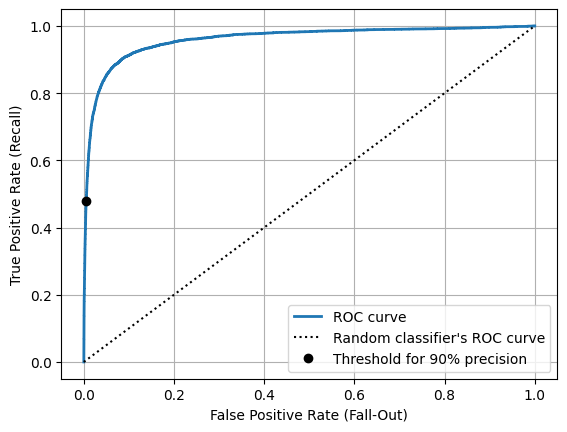

In [61]:
# Thresholds are listed in decreasing order this time
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.grid()



The higher the True Positive Rate, the higher the False Positive Rate

In [62]:
# Area Under Curve - The higher, the better
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [63]:
# Let's try a RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)


In [64]:
# RandomForestClassifier doesn't have a decision_function but
# it does have a predict_proba() function which returns class propabilities.
# We can use those as scores
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [65]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.98, 0.02]])

In [66]:
# the second column contains the estimated probabilities for the positive class
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

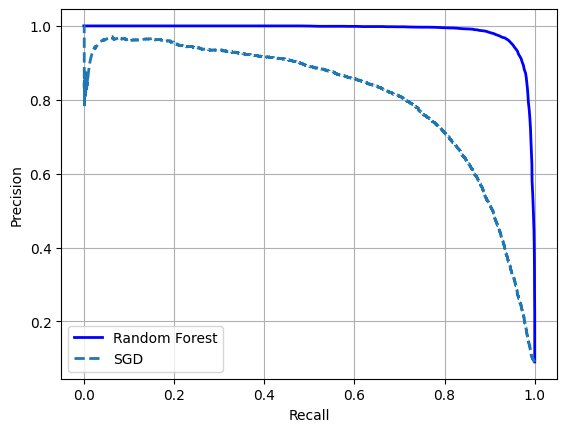

In [67]:
# Compare the two classifiers' curves
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()

In [68]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba >= 50%
print(f1_score(y_train_5, y_train_pred_forest))
print(roc_auc_score(y_train_5, y_scores_forest))

0.9270445185330457
0.9983296721818179


In [69]:
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9895331798199707
0.8719793396052389


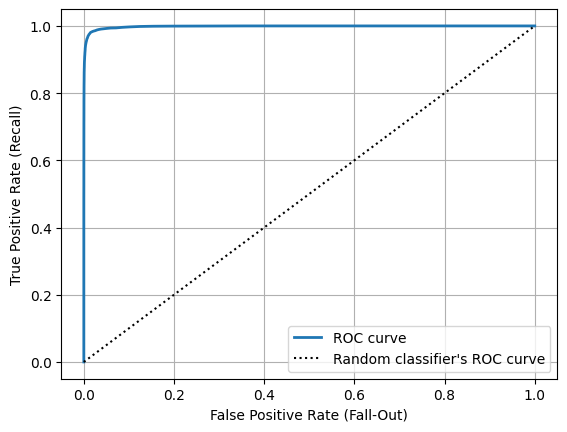

In [70]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr_forest, tpr_forest, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.grid()


### Multiclass classification

In [71]:
# Try a Support Vector Machine Classifier to detect all digits.
# It is a binary classifier, so sklearn will use OvO (One vs One) strategy
# since this strategy requires less training data and Support Vector Machines 
# do not scale well with the size of the training set.
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

In [72]:
# Actually makes 45 predictions - one per pair of classes - and selects the class
# that wins the most duels
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [73]:
# The decision function of the svm_clf returns the number of won duels per class
# (+/- a small tweak to break ties)
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [76]:
class_id = some_digit_scores.argmax()

In [75]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [77]:
svm_clf.classes_[class_id]

'5'

In [78]:
# Force sklearn to use a specific strategy (OvR or OvO):
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [79]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [80]:
len(ovr_clf.estimators_)

10

In [81]:
# Train an SGDClassifier on all the classes.
# Uses OvR strategy under the hood
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])  # Mistake!

array(['3'], dtype='<U1')

In [82]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [83]:
# Evaluate the model. Since there are roughly the same number of images
# in each class, the accuracy metric is fine
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [85]:
# Scaling the inputs increases accuracy
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error analysis

Text(0.5, 1.0, 'Confusion matrix')

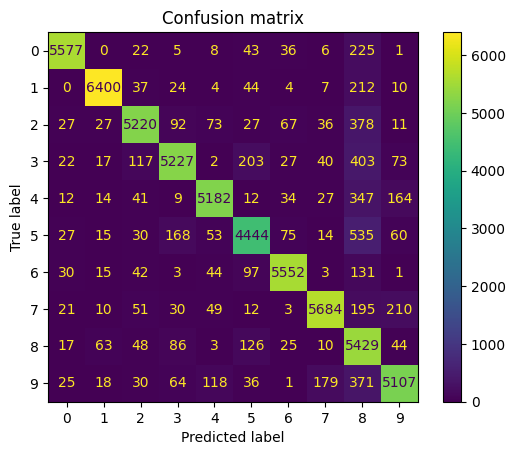

In [93]:
# Colored diagram of the confusion matrix for all the classes
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Confusion matrix")

Text(0.5, 1.0, 'CM normalized by row')

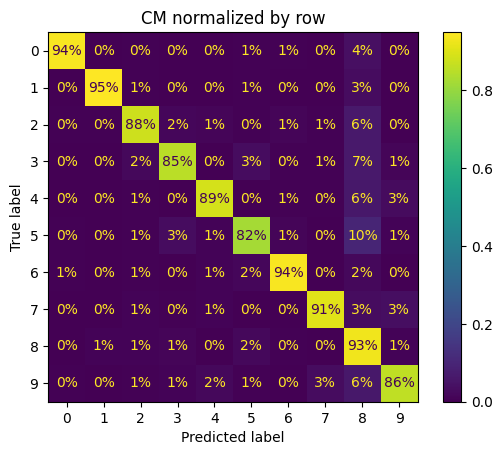

In [92]:
# Normalize the diagram: Divide each value by the row sum (-> total number of images in corresponding
# actual class). Otherwise, we can't know e.g. whether the cell (5, 5) of the matric (=4444) is so low
# because the model made many mistakes on the 5s or because there are fewer 5s than other digits 
# in the dataset.
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.title("CM normalized by row")

Now we can see that only 82% of the 5s were classified correctly.

Text(0.5, 1.0, 'Errors normalized by row')

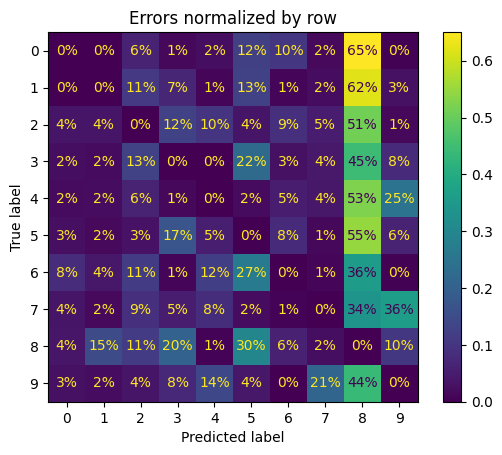

In [91]:
# make the errors stand out more
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.title("Errors normalized by row")

The 36% on cell (7, 9) means that 36% of the _errors_ the model made of images of 7s were misclassifications as 9s

Text(0.5, 1.0, 'Errors normalized by column')

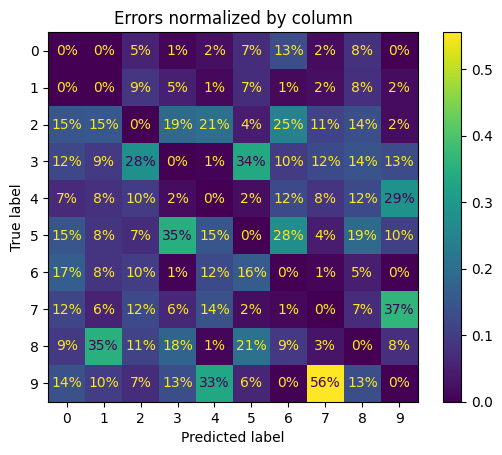

In [94]:
# Normalize by column rather than by row
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
plt.title("Errors normalized by column")

For example, 56% of misclassified 7s are actually 9s.

### Multilabel classification

In [95]:
# KneighborsClassifier supports multilabel classification

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [96]:
print(y_train[0])
print(y_train_large[0])
print(y_train_odd[0])
print(y_multilabel[0])

5
False
True
[False  True]


In [97]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [98]:
# Evaluate a multilabel classifier:
# Measure the f1_score for each individual label and compute the average score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [99]:
# I think the instances of "large" are way less than instances of "not large..."
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [100]:
# Chain classifier
from sklearn.multioutput import ClassifierChain

# Setting cv=3 makes the model later in the chain to use cross validated predictions
# for the previous label, instead of the actual true labels.
# E.g. the first model will be trained to classify digits as large or not large
# and the second model will be trained to classify digits as odd or not odd
# but will use the predictions of the previous models as extra features.
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [101]:
chain_clf.predict([some_digit])

array([[0., 1.]])

### Multioutput classification

It's a multilabel classification where each label can have more than two possible values

In [102]:
# Remove noise from images.
# The classifier's output is multilabel (one label per pixel) and each label can have
# multiple values (pixel intensity ranges from 0 to 255)
# First, create the noisy images

np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train  # the target images are the original images
y_test_mod = X_test

In [103]:
print(X_test.shape)
print(noise.shape)

(10000, 784)
(10000, 784)


(-0.5, 27.5, 27.5, -0.5)

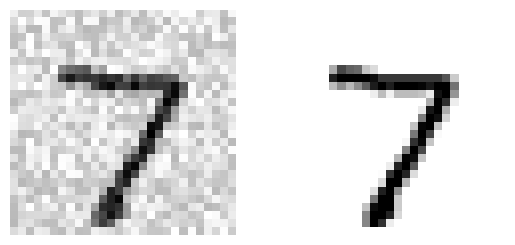

In [110]:
plt.subplot(121)
plt.imshow(X_test_mod[0].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.subplot(122)
plt.imshow(X_test[0].reshape(28, 28), cmap="binary")
plt.axis("off")

(-0.5, 27.5, 27.5, -0.5)

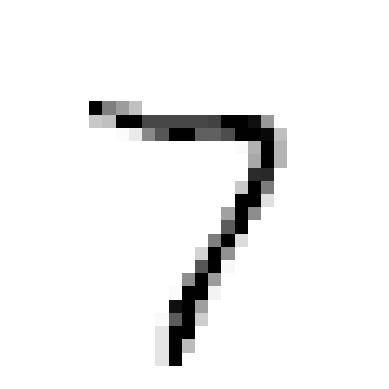

In [113]:
# Train the classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plt.imshow(clean_digit.reshape(28, 28), cmap="binary")
plt.axis("off")